In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import transform_fns as trans
import pdm_functions as fns
import tensor_vstack as pfns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import gaussian_kde
from sklearn.utils.class_weight import compute_class_weight

import pickle
from tqdm.notebook import tqdm


In [2]:
data_stacked = torch.load('data/spec_datasets.pt', weights_only=True)
X_train = data_stacked['X_train']
y_train = data_stacked['y_train']
X_train.shape, y_train.shape

(torch.Size([2600, 1, 36, 2048]), torch.Size([2600]))

In [3]:
len(y_train[y_train == 0]), len(y_train[y_train != 0])

(1170, 1430)

In [4]:
X_test = data_stacked['X_test']
y_test = data_stacked['y_test']
X_test.shape, y_test.shape

X_dev = data_stacked['X_dev']
y_dev = data_stacked['y_dev']
X_dev.shape, y_dev.shape

(torch.Size([370, 1, 36, 2048]), torch.Size([370]))

In [5]:
file_path='data/weight/5520_spectrum_x_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_x = torch.tensor(data)

file_path='data/weight/5520_spectrum_y_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_y = torch.tensor(data)

file_path='data/weight/5520_spectrum_z_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_z = torch.tensor(data)

wf_xyz = torch.stack((wf_x, wf_y, wf_z))
print(wf_x.shape, wf_y.shape, wf_z.shape, wf_xyz.shape)

torch.Size([2048]) torch.Size([2048]) torch.Size([2048]) torch.Size([3, 2048])


In [6]:
wf_broadcast = 100000

In [7]:
X_train_stacked = X_train * wf_xyz.repeat(12, 1) * wf_broadcast
X_dev_stacked = X_dev * wf_xyz.repeat(12, 1) * wf_broadcast
X_test_stacked = X_test * wf_xyz.repeat(12, 1) * wf_broadcast
# X_dev_stacked2 = X_dev_stacked2 * wf_xyz.repeat(12, 1)

<Axes: >

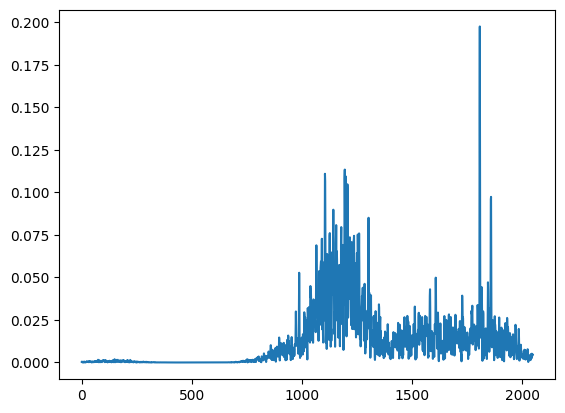

In [8]:
sns.lineplot(X_train_stacked[0][0][0])

In [9]:
train_dataset = TensorDataset(X_train_stacked, y_train)
test_dataset = TensorDataset(X_test_stacked, y_test)
dev_dataset = TensorDataset(X_dev_stacked, y_dev)

In [10]:
batch_size = 128
dataloader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size , shuffle=True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1)),  # First Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Conv2d(8, 32, kernel_size=(3, 1), stride=(3, 1)),  # Second Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Conv2d(32, 8, kernel_size=(12, 2), stride=(12, 2)),  # Third Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1)),  # Fourth Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(1024, 256), 
    nn.ReLU(),
    
    nn.Linear(256, 128),
    nn.ReLU(),
    
    nn.Linear(128, 64), 
    nn.ReLU(),
    
    nn.Linear(64, 16),
    nn.ReLU(),
    
    nn.Linear(16, 1)
        )

In [12]:
# 레이블 준비 (0: negative, 1: positive라고 가정)
y = np.array(dataloader_test.dataset[:][1]) 

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# BCEWithLogitsLoss에 사용할 pos_weight 계산
pos_weight = torch.tensor(class_weights[1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 30

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device)) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cuda


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Loss: 0.5083
Epoch [2/30], Loss: 0.4834
Epoch [3/30], Loss: 0.3268
Epoch [4/30], Loss: 0.1851
Epoch [5/30], Loss: 0.1137
Epoch [6/30], Loss: 0.0616
Epoch [7/30], Loss: 0.0451
Epoch [8/30], Loss: 0.0345
Epoch [9/30], Loss: 0.0184
Epoch [10/30], Loss: 0.0164
Epoch [11/30], Loss: 0.0211
Epoch [12/30], Loss: 0.0126
Epoch [13/30], Loss: 0.0208
Epoch [14/30], Loss: 0.0074
Epoch [15/30], Loss: 0.0104
Epoch [16/30], Loss: 0.0080
Epoch [17/30], Loss: 0.0060
Epoch [18/30], Loss: 0.0053
Epoch [19/30], Loss: 0.0068
Epoch [20/30], Loss: 0.0072
Epoch [21/30], Loss: 0.0088
Epoch [22/30], Loss: 0.0036
Epoch [23/30], Loss: 0.0139
Epoch [24/30], Loss: 0.0121
Epoch [25/30], Loss: 0.0118
Epoch [26/30], Loss: 0.0031
Epoch [27/30], Loss: 0.0014
Epoch [28/30], Loss: 0.0052
Epoch [29/30], Loss: 0.0024
Epoch [30/30], Loss: 0.0074


<Axes: >

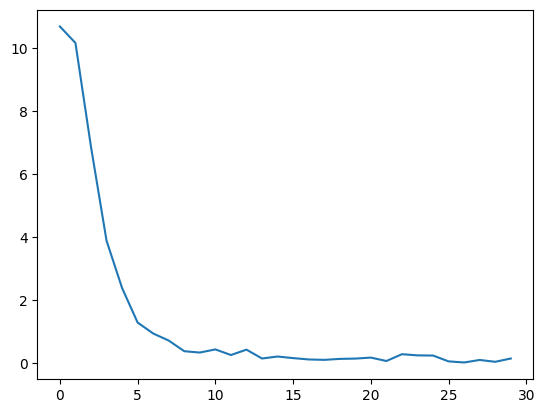

In [13]:
print(device)

model = model.to(device)
loss_plot = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for x_batch, labels in dataloader:
        optimizer.zero_grad()

        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device).float()
        labels = labels.unsqueeze(1)
        
        outputs = model(x_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    loss_plot.append(running_loss)
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

sns.lineplot(loss_plot)

In [24]:
dataset = dataloader_dev
threshold = 0.5

In [25]:
model.eval()

# Initialize variables to keep track of the loss and prediction
total_loss = 0.0
all_labels = []
all_predictions = []
correct_cnt = 0
neg_pred_cnt = 0

with torch.no_grad():
    for x_batch, labels in dataset:
        x_batch = x_batch.to(device)
        labels = labels.to(device).long()
        outputs = model(x_batch)  # Forward pass
        
        loss = criterion(outputs, labels.view(-1,1).float())  # Calculate loss
        total_loss += loss.item()  # Accumulate the loss
        
        # Get predictions
        predicted = (torch.sigmoid(outputs) > threshold).int()
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy().flatten())  # Store predicted labels

# Calculate average loss
avg_loss = total_loss / len(dataset)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
cm = confusion_matrix(all_labels, all_predictions)

TN = cm[0, 0]  
FP = cm[0, 1] 
FN = cm[1, 0]  
TP = cm[1, 1]  

# FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  
# FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  

Neg_precision = TN/(FN+TN) if (FN + TN) > 0 else 0   
Neg_recall =TN/(FP+TN) if (TN + FP) > 0 else 0  
 

# Print results

print(f"Evaluation Loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
# print(f'Predicted positives out of all negatives: {FPR} = {FP}/{FP + TN}')
# print(f'Predicted negatives out of all positives: {FNR} = {FN}/{FN + TP}')
print(all_labels)
print(all_predictions)
for i in range(len(all_labels)) :
    if all_labels[i] == 0 and all_predictions[i] == 0:
        correct_cnt += 1
for pred in all_predictions:
    if pred == 0:
        neg_pred_cnt += 1

print(f'correct_cnt {correct_cnt}')
print(f'neg_pred_cnt {neg_pred_cnt}')
print(f'Neg_Precision: {Neg_precision:.4f} = {TN}/{FN + TN}, Neg_Recall: {Neg_recall:.4f} = {TN}/{FP + TN}, Neg_F1:  {2* (Neg_precision * Neg_recall)/(Neg_precision + Neg_recall):.4f}') 
print(f"\nParameter - Weight : {wf_broadcast}, epoch : {num_epochs}, lr : {learning_rate}, threshold : {threshold}")

# len(all_labels) 

Evaluation Loss: 0.1925
Precision: 0.9489, Recall: 0.9459, F1 Score: 0.9332
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [16]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
  (1): Dropout(p=0.3, inplace=False)
  (2): ReLU()
  (3): Conv2d(8, 32, kernel_size=(3, 1), stride=(3, 1))
  (4): Dropout(p=0.3, inplace=False)
  (5): ReLU()
  (6): Conv2d(32, 8, kernel_size=(12, 2), stride=(12, 2))
  (7): Dropout(p=0.3, inplace=False)
  (8): ReLU()
  (9): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  (10): Dropout(p=0.3, inplace=False)
  (11): ReLU()
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=1024, out_features=256, bias=True)
  (14): ReLU()
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=64, bias=True)
  (18): ReLU()
  (19): Linear(in_features=64, out_features=16, bias=True)
  (20): ReLU()
  (21): Linear(in_features=16, out_features=1, bias=True)
)